In [1]:
import io
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa

In [2]:
import os  
import cv2
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder

# Loading np array from images
def make_dataset(labels, dir_path, IMG_SIZE = 150, size = 157):
    # initial an empty list X to store image of np.array()
    X = []

    # initial an empty list Z to store labels/names of cat individauls
    Z = []
    
    
    for label in labels:
        DIR = dir_path + label
        n = 0
        for img in tqdm(os.listdir(DIR)):
            if n != size: 
                path = os.path.join(DIR,img)
                # reading images
                img = cv2.imread(path,cv2.IMREAD_COLOR)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                # resizing images to (150, 150, 3), 3 is the number of channels - RGB
                img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))

                X.append(np.array(img))
                Z.append(str(label))
                
                n += 1
            
            else:
                break
            
    ## Transform labels in Z to Y from class number
    le=LabelEncoder()
    Y=le.fit_transform(Z)

    ## Transform and normalize X in the range of [0, 1]
    X=np.array(X, dtype=float)
    X=X/255.
    return X, Y

In [3]:
labels = np.array(['Arani', 'Inti', 'Ocuri', 'Poco', 'Rattaplan', 'Romy'])

dir_path = '/kaggle/input/auckland-zoom-monkeys/Auckland_Zoo_Monkeys/'

imsize = 150
EPOCHS = 10
batch_size = 64
embeddingDim = 128
num_individuals = len(labels)

In [4]:
from sklearn.neighbors import KNeighborsClassifier

lr = 0.001
k = 5


def acc_openset(lr, k, d_t, X_train, Y_train, X_test, Y_test):
    base_model_16 = tf.keras.applications.vgg16.VGG16(include_top=False,
                                                      input_shape = (imsize, imsize, 3),
                                                      weights = 'imagenet')

    # freeze all the layers of VGG, so they won't be trained.
    for layer in base_model_16.layers:
        layer.trainable = False

    model_tl = tf.keras.models.Sequential([
        base_model_16,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units=1024, activation='relu'),
        tf.keras.layers.Dense(embeddingDim, activation=None), # No activation on final dense layer
        tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1)) # L2 normalize embeddings
    ])

    model_tl.compile(
        optimizer=tf.keras.optimizers.Adam(lr),
        loss=tfa.losses.TripletSemiHardLoss())

    model_tl.fit(x = X_train, y = Y_train,
                 batch_size=batch_size,
                 epochs=EPOCHS,
                 verbose=1) 

    embedding_train_tl = []
    for i in range(len(Y_train)):
        embedding_train_tl.append(model_tl(X_train[i].reshape(1, imsize, imsize, 3))[0])

    embedding_train_tl = np.array(embedding_train_tl, dtype=float) 

    knn_tl = KNeighborsClassifier(n_neighbors = k)
    knn_tl.fit(embedding_train_tl, Y_train)

    #find the center point for each class in training set
    support_tl = []
    for i in np.unique(Y_train):
        support_tl.append(np.mean(embedding_train_tl[Y_train==i], axis=0))

    support_tl = np.array(support_tl, dtype=float)

    pred = []
    temp_x = np.append(X_test, X_test_unseen, axis=0)
    temp_y = np.append(Y_test, Y_test_unseen, axis=0)

    arr = np.arange(temp_y.shape[0])
    np.random.shuffle(arr)

    temp_x = temp_x[arr]
    temp_y = temp_y[arr]

    for i in range(len(temp_y)):
        dists = []
        for j in range(len(np.unique(Y_train))):
            embedding_test = model_tl(temp_x[i].reshape(1, 150, 150, 3))
            embedding_anchor = support_tl[j]
            dist = np.sum((embedding_test - embedding_anchor) ** 2) ** (1/2)
            dists.append(dist)
        if min(dists) >= d_t:
            pred.append('unseen')
        else:
            pred.append(knn_tl.predict(embedding_test)[0])

    pred = np.array(pred)

    acc_overall = round(np.mean(pred == temp_y), 2)
    acc_seen = round(np.mean(pred[temp_y != 'unseen'] == temp_y[temp_y != 'unseen']), 2)
    acc_unseen = round(np.mean(pred[temp_y == 'unseen'] == temp_y[temp_y == 'unseen']), 2)
    print('distance threshold is {}'.format(d_t))
    print('The accuracy overall is {}'.format(acc_overall))
    print('The accuracy of seen {}'.format(acc_seen))
    print('The accuracy of unseen {}'.format(acc_unseen))
    return acc_overall, acc_seen, acc_unseen

# 1. *Arani* as unseen

In [5]:
labels_seen =  np.array(['Inti', 'Ocuri', 'Poco', 'Rattaplan', 'Romy'])
labels_unseen = np.array(['Arani'])

In [6]:
X_seen, Y_seen = make_dataset(labels_seen, dir_path)
X_unseen, Y_unseen = make_dataset(labels_unseen, dir_path)
Y_unseen = ['unseen'] * len(Y_unseen)
Y_unseen = np.array(Y_unseen)

 65%|██████▌   | 157/240 [00:01<00:00, 94.03it/s] 


In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X_seen, Y_seen, test_size = 0.2, stratify = Y_seen, random_state=2021)
X_not_used_unseen, X_test_unseen, Y_not_used_unseen, Y_test_unseen = train_test_split(X_unseen, Y_unseen, test_size = 0.2, random_state=2021)

In [8]:
D_T = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
lr = 0.001
k = 5

acc_overall = []
acc_seen = []
acc_unseen = []

for d_t in D_T:
    overall, seen, unseen = acc_openset(lr, k, d_t, X_train, Y_train, X_test, Y_test)
    acc_overall.append(overall)
    acc_seen.append(seen)
    acc_unseen.append(unseen)

2021-10-19 10:46:28.925407: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-19 10:46:29.019238: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-19 10:46:29.020013: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-19 10:46:29.021151: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

58900480/58889256 [==============================] - 0s 0us/step


2021-10-19 10:46:32.415459: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2021-10-19 10:46:34.754711: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


10/10 [==============================] - 13s 309ms/step - loss: 0.9691
Epoch 2/10
10/10 [==============================] - 1s 64ms/step - loss: 0.9011
Epoch 3/10
10/10 [==============================] - 1s 64ms/step - loss: 0.8212
Epoch 4/10
10/10 [==============================] - 1s 65ms/step - loss: 0.7128
Epoch 5/10
10/10 [==============================] - 1s 64ms/step - loss: 0.5997
Epoch 6/10
10/10 [==============================] - 1s 67ms/step - loss: 0.4776
Epoch 7/10
10/10 [==============================] - 1s 65ms/step - loss: 0.3685
Epoch 8/10
10/10 [==============================] - 1s 64ms/step - loss: 0.2341
Epoch 9/10
10/10 [==============================] - 1s 65ms/step - loss: 0.1782
Epoch 10/10
10/10 [==============================] - 1s 64ms/step - loss: 0.0733
distance threshold is 0.1
The accuracy overall is 0.17
The accuracy of seen 0.0
The accuracy of unseen 1.0
Epoch 1/10
10/10 [==============================] - 1s 64ms/step - loss: 0.9737
Epoch 2/10
10/10 [===

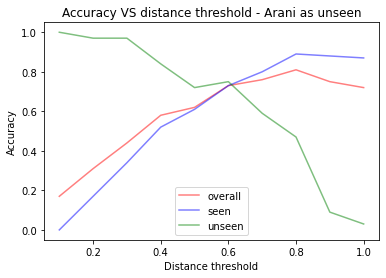

In [9]:
import matplotlib.pyplot as plt

plt.plot(D_T, acc_overall, color='red', alpha = 0.5, label = 'overall')
plt.plot(D_T, acc_seen,  color='blue', alpha = 0.5, label = 'seen')
plt.plot(D_T, acc_unseen, color='green', alpha = 0.5, label = 'unseen')
plt.title('Accuracy VS distance threshold - Arani as unseen')
plt.xlabel('Distance threshold')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('arani_unseen.png')
plt.show()

# 2. *Inti* as unseen

In [10]:
labels_seen =  np.array(['Arani', 'Ocuri', 'Poco', 'Rattaplan', 'Romy'])
labels_unseen = np.array(['Inti'])

X_seen, Y_seen = make_dataset(labels_seen, dir_path)
X_unseen, Y_unseen = make_dataset(labels_unseen, dir_path)
Y_unseen = ['unseen'] * len(Y_unseen)
Y_unseen = np.array(Y_unseen)

 38%|███▊      | 157/411 [00:00<00:00, 682.47it/s]


In [11]:
X_train, X_test, Y_train, Y_test = train_test_split(X_seen, Y_seen, test_size = 0.2, stratify = Y_seen, random_state=2021)
X_not_used_unseen, X_test_unseen, Y_not_used_unseen, Y_test_unseen = train_test_split(X_unseen, Y_unseen, test_size = 0.2, random_state=2021)

In [12]:
D_T = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
lr = 0.001
k = 5

acc_overall = []
acc_seen = []
acc_unseen = []

for d_t in D_T:
    overall, seen, unseen = acc_openset(lr, k, d_t, X_train, Y_train, X_test, Y_test)
    acc_overall.append(overall)
    acc_seen.append(seen)
    acc_unseen.append(unseen)

Epoch 1/10
10/10 [==============================] - 1s 65ms/step - loss: 0.9703
Epoch 2/10
10/10 [==============================] - 1s 64ms/step - loss: 0.9161
Epoch 3/10
10/10 [==============================] - 1s 64ms/step - loss: 0.9110
Epoch 4/10
10/10 [==============================] - 1s 64ms/step - loss: 0.7219
Epoch 5/10
10/10 [==============================] - 1s 64ms/step - loss: 0.5736
Epoch 6/10
10/10 [==============================] - 1s 64ms/step - loss: 0.4256
Epoch 7/10
10/10 [==============================] - 1s 65ms/step - loss: 0.3240
Epoch 8/10
10/10 [==============================] - 1s 67ms/step - loss: 0.1976
Epoch 9/10
10/10 [==============================] - 1s 65ms/step - loss: 0.1376
Epoch 10/10
10/10 [==============================] - 1s 64ms/step - loss: 0.0521
distance threshold is 0.1
The accuracy overall is 0.17
The accuracy of seen 0.01
The accuracy of unseen 1.0
Epoch 1/10
10/10 [==============================] - 1s 64ms/step - loss: 0.9670
Epoch 2/10


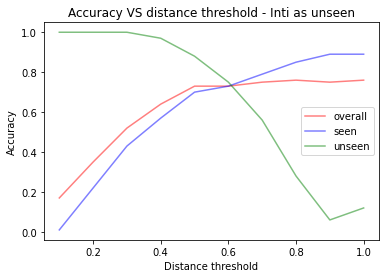

In [13]:
import matplotlib.pyplot as plt

plt.plot(D_T, acc_overall, color='red', alpha = 0.5, label = 'overall')
plt.plot(D_T, acc_seen,  color='blue', alpha = 0.5, label = 'seen')
plt.plot(D_T, acc_unseen, color='green', alpha = 0.5, label = 'unseen')
plt.title('Accuracy VS distance threshold - Inti as unseen')
plt.xlabel('Distance threshold')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('inti_unseen.png')
plt.show()

# 3. *Ocuri* as unseen

In [14]:
labels_seen =  np.array(['Arani', 'Inti', 'Poco', 'Rattaplan', 'Romy'])
labels_unseen = np.array(['Ocuri'])

X_seen, Y_seen = make_dataset(labels_seen, dir_path)
X_unseen, Y_unseen = make_dataset(labels_unseen, dir_path)
Y_unseen = ['unseen'] * len(Y_unseen)
Y_unseen = np.array(Y_unseen)

X_train, X_test, Y_train, Y_test = train_test_split(X_seen, Y_seen, test_size = 0.2, stratify = Y_seen, random_state=2021)
X_not_used_unseen, X_test_unseen, Y_not_used_unseen, Y_test_unseen = train_test_split(X_unseen, Y_unseen, test_size = 0.2, random_state=2021)

 30%|██▉       | 157/530 [00:00<00:01, 296.46it/s]


In [15]:
D_T = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
lr = 0.001
k = 5

acc_overall = []
acc_seen = []
acc_unseen = []

for d_t in D_T:
    overall, seen, unseen = acc_openset(lr, k, d_t, X_train, Y_train, X_test, Y_test)
    acc_overall.append(overall)
    acc_seen.append(seen)
    acc_unseen.append(unseen)

Epoch 1/10
10/10 [==============================] - 1s 66ms/step - loss: 0.9720
Epoch 2/10
10/10 [==============================] - 1s 66ms/step - loss: 0.9251
Epoch 3/10
10/10 [==============================] - 1s 64ms/step - loss: 0.8369
Epoch 4/10
10/10 [==============================] - 1s 65ms/step - loss: 0.7466
Epoch 5/10
10/10 [==============================] - 1s 64ms/step - loss: 0.6198
Epoch 6/10
10/10 [==============================] - 1s 64ms/step - loss: 0.5043
Epoch 7/10
10/10 [==============================] - 1s 64ms/step - loss: 0.2922
Epoch 8/10
10/10 [==============================] - 1s 64ms/step - loss: 0.1940
Epoch 9/10
10/10 [==============================] - 1s 64ms/step - loss: 0.1119
Epoch 10/10
10/10 [==============================] - 1s 64ms/step - loss: 0.0583
distance threshold is 0.1
The accuracy overall is 0.17
The accuracy of seen 0.01
The accuracy of unseen 1.0
Epoch 1/10
10/10 [==============================] - 2s 64ms/step - loss: 0.9807
Epoch 2/10


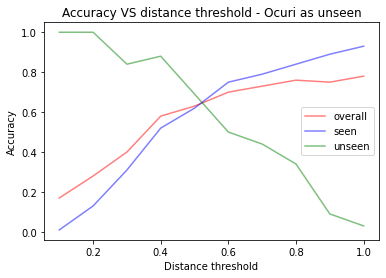

In [16]:
import matplotlib.pyplot as plt

plt.plot(D_T, acc_overall, color='red', alpha = 0.5, label = 'overall')
plt.plot(D_T, acc_seen,  color='blue', alpha = 0.5, label = 'seen')
plt.plot(D_T, acc_unseen, color='green', alpha = 0.5, label = 'unseen')
plt.title('Accuracy VS distance threshold - Ocuri as unseen')
plt.xlabel('Distance threshold')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('ocuri_unseen.png')
plt.show()

# 4. *Poco* as unseen

In [17]:
labels_seen =  np.array(['Arani', 'Inti', 'Ocuri', 'Rattaplan', 'Romy'])
labels_unseen = np.array(['Poco'])

X_seen, Y_seen = make_dataset(labels_seen, dir_path)
X_unseen, Y_unseen = make_dataset(labels_unseen, dir_path)
Y_unseen = ['unseen'] * len(Y_unseen)
Y_unseen = np.array(Y_unseen)

X_train, X_test, Y_train, Y_test = train_test_split(X_seen, Y_seen, test_size = 0.2, stratify = Y_seen, random_state=2021)
X_not_used_unseen, X_test_unseen, Y_not_used_unseen, Y_test_unseen = train_test_split(X_unseen, Y_unseen, test_size = 0.2, random_state=2021)

 55%|█████▌    | 157/285 [00:00<00:00, 414.68it/s]


In [18]:
D_T = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
lr = 0.001
k = 5

acc_overall = []
acc_seen = []
acc_unseen = []

for d_t in D_T:
    overall, seen, unseen = acc_openset(lr, k, d_t, X_train, Y_train, X_test, Y_test)
    acc_overall.append(overall)
    acc_seen.append(seen)
    acc_unseen.append(unseen)

Epoch 1/10
10/10 [==============================] - 1s 68ms/step - loss: 0.9787
Epoch 2/10
10/10 [==============================] - 1s 66ms/step - loss: 0.8961
Epoch 3/10
10/10 [==============================] - 1s 65ms/step - loss: 0.8145
Epoch 4/10
10/10 [==============================] - 1s 65ms/step - loss: 0.7164
Epoch 5/10
10/10 [==============================] - 1s 65ms/step - loss: 0.6554
Epoch 6/10
10/10 [==============================] - 1s 64ms/step - loss: 0.5886
Epoch 7/10
10/10 [==============================] - 1s 64ms/step - loss: 0.4777
Epoch 8/10
10/10 [==============================] - 1s 64ms/step - loss: 0.4114
Epoch 9/10
10/10 [==============================] - 1s 64ms/step - loss: 0.2979
Epoch 10/10
10/10 [==============================] - 1s 63ms/step - loss: 0.1500
distance threshold is 0.1
The accuracy overall is 0.17
The accuracy of seen 0.0
The accuracy of unseen 1.0
Epoch 1/10
10/10 [==============================] - 1s 67ms/step - loss: 0.9788
Epoch 2/10
1

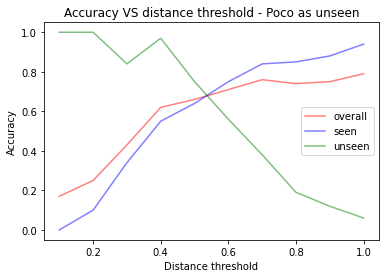

In [19]:
import matplotlib.pyplot as plt

plt.plot(D_T, acc_overall, color='red', alpha = 0.5, label = 'overall')
plt.plot(D_T, acc_seen,  color='blue', alpha = 0.5, label = 'seen')
plt.plot(D_T, acc_unseen, color='green', alpha = 0.5, label = 'unseen')
plt.title('Accuracy VS distance threshold - Poco as unseen')
plt.xlabel('Distance threshold')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('poco_unseen.png')
plt.show()

# 5. *Rattaplan* as unseen

In [20]:
labels_seen =  np.array(['Arani', 'Inti', 'Ocuri', 'Poco', 'Romy'])
labels_unseen = np.array(['Rattaplan'])

X_seen, Y_seen = make_dataset(labels_seen, dir_path)
X_unseen, Y_unseen = make_dataset(labels_unseen, dir_path)
Y_unseen = ['unseen'] * len(Y_unseen)
Y_unseen = np.array(Y_unseen)

X_train, X_test, Y_train, Y_test = train_test_split(X_seen, Y_seen, test_size = 0.2, stratify = Y_seen, random_state=2021)
X_not_used_unseen, X_test_unseen, Y_not_used_unseen, Y_test_unseen = train_test_split(X_unseen, Y_unseen, test_size = 0.2, random_state=2021)

100%|██████████| 157/157 [00:00<00:00, 416.77it/s]


In [21]:
D_T = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
lr = 0.001
k = 5

acc_overall = []
acc_seen = []
acc_unseen = []

for d_t in D_T:
    overall, seen, unseen = acc_openset(lr, k, d_t, X_train, Y_train, X_test, Y_test)
    acc_overall.append(overall)
    acc_seen.append(seen)
    acc_unseen.append(unseen)

Epoch 1/10
10/10 [==============================] - 2s 69ms/step - loss: 0.9750
Epoch 2/10
10/10 [==============================] - 1s 69ms/step - loss: 0.9251
Epoch 3/10
10/10 [==============================] - 1s 65ms/step - loss: 0.8245
Epoch 4/10
10/10 [==============================] - 1s 64ms/step - loss: 0.7893
Epoch 5/10
10/10 [==============================] - 1s 64ms/step - loss: 0.6687
Epoch 6/10
10/10 [==============================] - 1s 65ms/step - loss: 0.5386
Epoch 7/10
10/10 [==============================] - 1s 64ms/step - loss: 0.4172
Epoch 8/10
10/10 [==============================] - 1s 65ms/step - loss: 0.2759
Epoch 9/10
10/10 [==============================] - 1s 64ms/step - loss: 0.1920
Epoch 10/10
10/10 [==============================] - 1s 64ms/step - loss: 0.1324
distance threshold is 0.1
The accuracy overall is 0.17
The accuracy of seen 0.0
The accuracy of unseen 1.0
Epoch 1/10
10/10 [==============================] - 1s 65ms/step - loss: 0.9758
Epoch 2/10
1

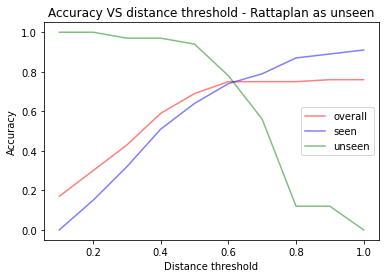

In [22]:
import matplotlib.pyplot as plt

plt.plot(D_T, acc_overall, color='red', alpha = 0.5, label = 'overall')
plt.plot(D_T, acc_seen,  color='blue', alpha = 0.5, label = 'seen')
plt.plot(D_T, acc_unseen, color='green', alpha = 0.5, label = 'unseen')
plt.title('Accuracy VS distance threshold - Rattaplan as unseen')
plt.xlabel('Distance threshold')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('rattaplan_unseen.png')
plt.show()

# 6. *Romy* as unseen

In [23]:
labels_seen =  np.array(['Arani', 'Inti', 'Ocuri', 'Poco', 'Rattaplan'])
labels_unseen = np.array(['Romy'])

X_seen, Y_seen = make_dataset(labels_seen, dir_path)
X_unseen, Y_unseen = make_dataset(labels_unseen, dir_path)
Y_unseen = ['unseen'] * len(Y_unseen)
Y_unseen = np.array(Y_unseen)

X_train, X_test, Y_train, Y_test = train_test_split(X_seen, Y_seen, test_size = 0.2, stratify = Y_seen, random_state=2021)
X_not_used_unseen, X_test_unseen, Y_not_used_unseen, Y_test_unseen = train_test_split(X_unseen, Y_unseen, test_size = 0.2, random_state=2021)

 73%|███████▎  | 157/214 [00:00<00:00, 653.90it/s]


In [24]:
D_T = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
lr = 0.001
k = 5

acc_overall = []
acc_seen = []
acc_unseen = []

for d_t in D_T:
    overall, seen, unseen = acc_openset(lr, k, d_t, X_train, Y_train, X_test, Y_test)
    acc_overall.append(overall)
    acc_seen.append(seen)
    acc_unseen.append(unseen)

Epoch 1/10
10/10 [==============================] - 1s 65ms/step - loss: 0.9802
Epoch 2/10
10/10 [==============================] - 1s 65ms/step - loss: 0.9487
Epoch 3/10
10/10 [==============================] - 1s 64ms/step - loss: 0.9186
Epoch 4/10
10/10 [==============================] - 1s 65ms/step - loss: 0.8091
Epoch 5/10
10/10 [==============================] - 1s 66ms/step - loss: 0.7073
Epoch 6/10
10/10 [==============================] - 1s 64ms/step - loss: 0.5681
Epoch 7/10
10/10 [==============================] - 1s 65ms/step - loss: 0.4787
Epoch 8/10
10/10 [==============================] - 1s 64ms/step - loss: 0.3996
Epoch 9/10
10/10 [==============================] - 1s 63ms/step - loss: 0.2711
Epoch 10/10
10/10 [==============================] - 1s 64ms/step - loss: 0.2202
distance threshold is 0.1
The accuracy overall is 0.18
The accuracy of seen 0.01
The accuracy of unseen 1.0
Epoch 1/10
10/10 [==============================] - 1s 65ms/step - loss: 0.9814
Epoch 2/10


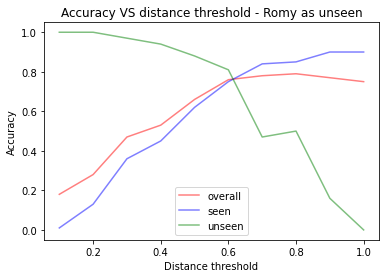

In [25]:
import matplotlib.pyplot as plt

plt.plot(D_T, acc_overall, color='red', alpha = 0.5, label = 'overall')
plt.plot(D_T, acc_seen,  color='blue', alpha = 0.5, label = 'seen')
plt.plot(D_T, acc_unseen, color='green', alpha = 0.5, label = 'unseen')
plt.title('Accuracy VS distance threshold - Romy as unseen')
plt.xlabel('Distance threshold')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('romy_unseen.png')
plt.show()